Ich möchte hier verschiedenen Fragen zu den Sensoren der SGC-K nachgehen:
1) Wie viele Sensoren haben wir?
2) Wie viele Aufnahmen haben die Sensoren gemacht? Haben Sie unterschiedlich viele gemacht?
3) Haben die Sensoren synchron zueinander Aufnahmen gemacht?
4) Wie kann man die Sensoren trotz a-synchronität miteinander vergleichen?
5) Welche Temperaturunterschiede zwischen gleichzeitig gemachten Aufnahmen lassen sich feststellen? 
6) Wann sind welche Sensoren fehlerhaft geworden?


In [2]:
%pip install plotly --upgrade

  Using cached plotly-6.0.0-py3-none-any.whl.metadata (5.6 kB)
  Using cached narwhals-1.24.2-py3-none-any.whl.metadata (10 kB)
Using cached plotly-6.0.0-py3-none-any.whl (14.8 MB)
Using cached narwhals-1.24.2-py3-none-any.whl (312 kB)
Note: you may need to restart the kernel to use updated packages.


In [3]:
# imports
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

# read the csv file
filepath = "/Users/richie/Projects/SGC-K/data/data_weather_stations_2024.csv"
df_K = pd.read_csv(filepath)
df_edit = df_K.copy()


In [7]:
# general information
print(df_edit.shape)

(276307, 13)


## Zu 1. Wie viele Sensoren haben wir? 


In [10]:
# retrieve unique names
df_edit["name"].unique() 

"""Es gibt 12 Sensoren."""

array(['Marktstätte', 'Herose-Park', 'Mainaustrasse', 'Fähre Staad',
       'Hörnle', 'Riedstrasse', 'Europapark', 'Stadtgarten', 'Bodanplatz',
       'Friedrichstrasse', 'Döbele', 'Stephansplatz'], dtype=object)

## Zu 2. Wie viele Aufnahmen haben die Sensoren jeweils gemacht? 

Hörnle              34512
Stadtgarten         26199
Mainaustrasse       25515
Riedstrasse         23593
Stephansplatz       23207
Fähre Staad         22100
Bodanplatz          21806
Marktstätte         21782
Friedrichstrasse    21637
Herose-Park         21316
Europapark          17725
Döbele              16915
Name: name, dtype: int64


' Die Sensoren haben unterschiedlich viele Aufnahmen. Hörnle am meißten und Döbele am wenigsten. Das ist aber komisch, da die seit Dezember \nabgeschalteten: \n    Stadtgarten: 24.12.2024, 21:23\n    Stephansplatz: 12.12.2024, 04:06\n    Bodanplatz: 21.12.2024, 08:03\n    Friederichsstraße : 20.12.2024, 07:06\n    sind. Aber Stadtgarten hat immernoch am zweitmeißten Aufnahmen insgesamt. \n'

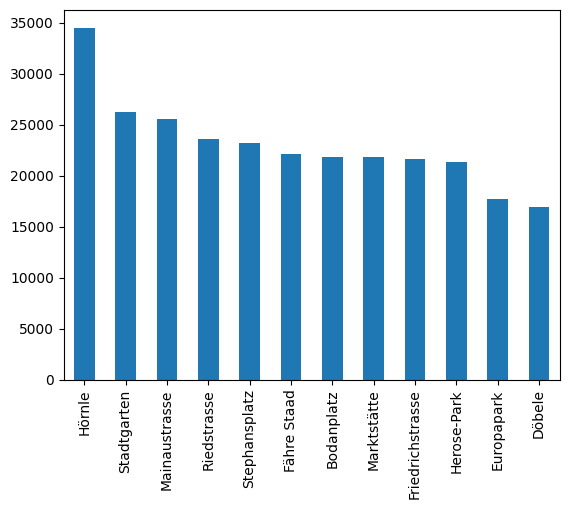

In [22]:
# count number of "name"-occurrence 
measurements = df_edit["name"].value_counts()

print(measurements)
ax = measurements.plot.bar(x='Standort Messgerät', y='Anzahl Messungen', rot=90)


""" Die Sensoren haben unterschiedlich viele Aufnahmen. Hörnle am meißten und Döbele am wenigsten. Das ist aber komisch, da die seit Dezember 
abgeschalteten: 
    Stadtgarten: 24.12.2024, 21:23
    Stephansplatz: 12.12.2024, 04:06
    Bodanplatz: 21.12.2024, 08:03
    Friederichsstraße : 20.12.2024, 07:06
    sind. Aber Stadtgarten hat immernoch am zweitmeißten Aufnahmen insgesamt. 
"""

## Zu 3. Haben die Sensoren synchron zueinander Aufnahmen gemacht?

In [5]:
#name and date and temperature (ndt)
df_ndt = df_K[['name','dateobserved','temperature']].copy()
print(df_ndt)

# change timestamps to timezone-naive values (utc as arguments since some entries have ms and somes dont) 
# From entries with +01 and +02 the hours are subtracted respectively
df_ndt['dateobserved'] = pd.to_datetime(df_ndt['dateobserved'],utc=True).dt.tz_convert(None)
print(df_ndt)

#First I will check if there are dates that occur 12 times ( in this case all 12 stations would have measured values at the exact same time)
#Reshape your data so that each row represents a unique timestamp, and each column corresponds to a name's sensed temperature:
df_pivot = df_ndt.pivot(index="dateobserved", columns="name", values="temperature")

# checkout number of NAN cells before pivoting = 0 (so, before we did not have any missing values in the temperature column)
print("NaNs before pivoting:", df_ndt["temperature"].isna().sum())
print("NaNs after pivoting:", df_pivot.isna().sum().sum()) # after pivoting, we have 3020297 missing values, meaning that measurements 
# have been taken at time points, where other stations have not measured. 
print(len(df_ndt))

#If we try to check if there are dates that have no NAN value in any column:
df_valid = df_pivot.dropna()
print(len(df_valid)) # No, all measurements have some NAN somewhere. So we cannot compare the exact dates. 


                    name                dateobserved  temperature
0            Marktstätte  2024-12-31 23:58:54.822+01       -1.600
1            Herose-Park  2024-12-31 23:55:11.541+01       -1.300
2          Mainaustrasse  2024-12-31 23:53:21.901+01       -1.600
3            Fähre Staad  2024-12-31 23:52:12.075+01       -1.700
4                 Hörnle  2024-12-31 23:51:25.294+01       -1.900
...                  ...                         ...          ...
276302       Fähre Staad      2024-04-09 16:27:57+02        9.299
276303  Friedrichstrasse      2024-04-09 16:27:40+02        9.299
276304     Mainaustrasse      2024-04-09 16:25:13+02        9.500
276305        Europapark      2024-04-09 16:22:16+02        9.099
276306       Stadtgarten      2024-04-09 16:21:44+02        9.400

[276307 rows x 3 columns]
                    name            dateobserved  temperature
0            Marktstätte 2024-12-31 22:58:54.822       -1.600
1            Herose-Park 2024-12-31 22:55:11.541       -1

## Zu 4. Wie kann man die Sensoren dennoch miteinander vergleichen?

In [23]:
# One approach: resample the data to time bins of 15 minutes to have comparability
#new variable 
df_timebin = df_K[['name','dateobserved','temperature']].copy()

# From entries with +01 and +02 the hours are subtracted respectively
df_timebin['dateobserved'] = pd.to_datetime(df_timebin['dateobserved'],utc=True).dt.tz_convert(None)

# Set 'dates' as index
df_timebin.set_index("dateobserved", inplace=True)

# Resample the data to 15-minute intervals 
df_timebin = df_timebin.groupby('name').resample('15T').mean().reset_index()

print("NaNs after resampling:", df_timebin.isna().sum().sum()) # I still have 44910 NANs within the 15 min time bins of 300382 total

print("Nulls after resampling:", df_timebin.isnull().sum().sum()) # I still have 44910 NANs within the 15 min time bins of 300382 total


# lets find time bins where there are no Nan values across all names 
df_no_nans = df_timebin.dropna(subset=['temperature'])
len(df_no_nans)

zero_values = df_no_nans[df_no_nans['temperature'] == 0]
print(f"Number of zero values in 'temperature': {len(zero_values)}")

# 255472 without nans, comparabla time bins 
df_no_nans.to_csv("/Users/richie/temps_no_nan.csv")


/var/folders/k5/njyjkt_x2mg0jkrvd3g_wnhc0000gn/T/ipykernel_17923/3354623940.py:12: FutureWarning:

The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.



NaNs after resampling: 44910
Nulls after resampling: 44910
Number of zero values in 'temperature': 622


## Zu 5. Welche Temperaturunterschiede zwischen gleichzeitig gemachten Aufnahmen lassen sich feststellen? 

In [2]:
# Filter out rows where 'dateobserved' (which is now an index) falls in summer (June, July, August) at exactly 12:00
df_filtered = df_no_nans[
    (df_no_nans['dateobserved'].dt.month.isin([7])) &  # Summer months
    (df_no_nans['dateobserved'].dt.hour == 12)              # 12:00 PM
]

# Check for rows where 'temperature' equals 0 in df_filtered
zero_values = df_filtered[df_filtered['temperature'] == 0]
print(f"Number of zero values in 'temperature' in df_filtered: {len(zero_values)}")

# Get one temperature reading per 'name' by using groupby and taking the first entry per name
df_one_per_name = df_filtered.groupby("name").first().reset_index()

print(df_one_per_name)

#Wir könnten auch uns einmal den gesamten Monat Juli darstellen: 
#Wir nehmen die Temperaturmessungen innerhalb der vergleichbaren Zeitintervalle für jeden Namen seperat und plotten die zusammen in ein Diagramm
line_fig = px.line(df_filtered, x="dateobserved", y="temperature", color = "name", title="Messwerte im Monat Juli alle 15 Minuten")
area_fig = px.area(df_filtered, x="dateobserved", y="temperature", color = "name", title="Messwerte im Monat Juli alle 15 Minuten")
line_fig

# was ich nicht verstehe sind vereinzelnte 0 Werte im Area plot


NameError: name 'df_no_nans' is not defined

## Zu 6. Wann sind welche Sensoren fehlerhaft geworden? 

### aus dem GUI: 
#### Nichtaktuell sind
1) Stadtgarten: 24.12.2024, 21:23
2) Stephansplatz: 12.12.2024, 04:06
3) Bodanplatz: 21.12.2024, 08:03
4) Friederichsstraße : 20.12.2024, 07:06

#### Aktuell sind:
- Europapark
- Herose-Platz
- Mainaustraße
- Riedstrasse
- Fähre Staad
- Hörnle
- Marktstätte

#### Nicht eingetragen im GUI: 
- DÖBELE


## Zu 7. Vergleich zu dem Deutschen Wetter Messpunkt 

In [1]:
"""
Station Nummer 2712 in Konstanz. Die Daten decken die Zeitspanne 1973 bis 2024 ab.

Die Messstation Konstanz befindet sich seit Oktober 2020 westlich der L221 in einem landwirtschaftlich genutzten Gebiet. 
Nach internationalen Richtlinien ist der Standort nahezu ideal – die dort gemessenen Werte 
sind aber nicht repräsentativ für das Stadtklima, denn die Temperaturen in der Stadt sind meist höher als im ländlichen Raum.
Wetterstation-ID = 02712
"""
#dwd_daten_path = "/Users/richie/Projects/SGC-K/data/produkt_zehn_min_tu_20230803_20250202_02712.txt"

# STATIONS_ID;MESS_DATUM;  QN;PP_10;TT_10;TM5_10;RF_10;TD_10;eor
# Relative Feuchte, Luftdruck auf Stationshöhe, Temperatur am Erdboden, Temperatur in 2 m, Taupunkttemperatur
#data = pd.read_fwf(dwd_daten_path, sep=";")
#print(type(data))
#print(data.head())
#data.columns = ["Luftdruck", "Temperatur_Boden", "Temperatur_2m", "Taupunkttemperatur"]


'\nStation Nummer 2712 in Konstanz. Die Daten decken die Zeitspanne 1973 bis 2024 ab.\n\nDie Messstation Konstanz befindet sich seit Oktober 2020 westlich der L221 in einem landwirtschaftlich genutzten Gebiet. \nNach internationalen Richtlinien ist der Standort nahezu ideal – die dort gemessenen Werte \nsind aber nicht repräsentativ für das Stadtklima, denn die Temperaturen in der Stadt sind meist höher als im ländlichen Raum.\nWetterstation-ID = 02712\n'

## Offene Fragen

- Woher kommen diese ungleichen Zahlen in den Aufnahmen, ist das noch normal?
- Ist es legitim die Temperaturen in solchen Zeitcontainern (á 15 min) zu vergleichen mit gemittelten Werten?
- Was ist mit Döbele?
- Wo messen die Sensoren die Temperatur? Boden oder 2m über Boden oder?
  